In [1]:
from keras.datasets import mnist
import numpy as np

%matplotlib inline


from time import time, sleep
import matplotlib.pyplot as plt
from IPython import display

from sklearn.metrics import accuracy_score

(X_train, y_train), (X_test, y_test) = mnist.load_data()
mean = 255./2
X_train = (X_train.astype('float32') - mean) / 255.
X_test  = (X_test .astype('float32')- mean) / 255.

X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)


Using TensorFlow backend.


    8192/11490434 [..............................] - ETA: 3:16

   24576/11490434 [..............................] - ETA: 2:16

   40960/11490434 [..............................] - ETA: 2:00

   57344/11490434 [..............................] - ETA: 1:54

   73728/11490434 [..............................] - ETA: 1:50

   90112/11490434 [..............................] - ETA: 2:04

  106496/11490434 [..............................] - ETA: 2:00

  122880/11490434 [..............................] - ETA: 1:56

  139264/11490434 [..............................] - ETA: 1:54

  163840/11490434 [..............................] - ETA: 1:45

  180224/11490434 [..............................] - ETA: 1:45

  196608/11490434 [..............................] - ETA: 1:44

  229376/11490434 [..............................] - ETA: 1:36

  245760/11490434 [..............................] - ETA: 1:36

  262144/11490434 [..............................] - ETA: 1:36

  278528/11490434 [..............................] - ETA: 1:35

  303104/11490434 [..............................] - ETA: 1:32

  335872/11490434 [..............................] - ETA: 1:28

  352256/11490434 [..............................] - ETA: 1:28

  368640/11490434 [..............................] - ETA: 1:27

  401408/11490434 [>.............................] - ETA: 1:25

  434176/11490434 [>.............................] - ETA: 1:21

  458752/11490434 [>.............................] - ETA: 1:20

  491520/11490434 [>.............................] - ETA: 1:18

  507904/11490434 [>.............................] - ETA: 1:18

  540672/11490434 [>.............................] - ETA: 1:16

  581632/11490434 [>.............................] - ETA: 1:13

  598016/11490434 [>.............................] - ETA: 1:13

  630784/11490434 [>.............................] - ETA: 1:11

  663552/11490434 [>.............................] - ETA: 1:10

  696320/11490434 [>.............................] - ETA: 1:09

  737280/11490434 [>.............................] - ETA: 1:07

  770048/11490434 [=>............................] - ETA: 1:06

  802816/11490434 [=>............................] - ETA: 1:05

  835584/11490434 [=>............................] - ETA: 1:04

  876544/11490434 [=>............................] - ETA: 1:02

  909312/11490434 [=>............................] - ETA: 1:01

  942080/11490434 [=>............................] - ETA: 1:00

  958464/11490434 [=>............................] - ETA: 1:00

  974848/11490434 [=>............................] - ETA: 59s 

  999424/11490434 [=>............................] - ETA: 58s

 1032192/11490434 [=>............................] - ETA: 57s

 1064960/11490434 [=>............................] - ETA: 57s

 1081344/11490434 [=>............................] - ETA: 56s

 1114112/11490434 [=>............................] - ETA: 55s

 1155072/11490434 [==>...........................] - ETA: 54s

 1171456/11490434 [==>...........................] - ETA: 54s

 1204224/11490434 [==>...........................] - ETA: 53s

 1236992/11490434 [==>...........................] - ETA: 52s

 1253376/11490434 [==>...........................] - ETA: 52s

 1294336/11490434 [==>...........................] - ETA: 50s

 1327104/11490434 [==>...........................] - ETA: 50s

 1343488/11490434 [==>...........................] - ETA: 49s

 1376256/11490434 [==>...........................] - ETA: 49s

 1417216/11490434 [==>...........................] - ETA: 47s

 1449984/11490434 [==>...........................] - ETA: 47s

 1466368/11490434 [==>...........................] - ETA: 46s

 1515520/11490434 [==>...........................] - ETA: 45s

 1556480/11490434 [===>..........................] - ETA: 44s

 1572864/11490434 [===>..........................] - ETA: 44s

 1605632/11490434 [===>..........................] - ETA: 44s

 1638400/11490434 [===>..........................] - ETA: 43s

 1671168/11490434 [===>..........................] - ETA: 42s

 1712128/11490434 [===>..........................] - ETA: 42s

 1744896/11490434 [===>..........................] - ETA: 41s

 1761280/11490434 [===>..........................] - ETA: 41s

 1794048/11490434 [===>..........................] - ETA: 40s

 1835008/11490434 [===>..........................] - ETA: 40s

 1867776/11490434 [===>..........................] - ETA: 39s

 1900544/11490434 [===>..........................] - ETA: 39s

 1933312/11490434 [====>.........................] - ETA: 38s

 1949696/11490434 [====>.........................] - ETA: 38s

 1974272/11490434 [====>.........................] - ETA: 38s

 2023424/11490434 [====>.........................] - ETA: 37s

 2056192/11490434 [====>.........................] - ETA: 37s

 2088960/11490434 [====>.........................] - ETA: 37s

 2129920/11490434 [====>.........................] - ETA: 36s

 2146304/11490434 [====>.........................] - ETA: 36s

 2195456/11490434 [====>.........................] - ETA: 35s

 2211840/11490434 [====>.........................] - ETA: 35s

 2252800/11490434 [====>.........................] - ETA: 35s

 2285568/11490434 [====>.........................] - ETA: 34s

 2318336/11490434 [=====>........................] - ETA: 34s

 2334720/11490434 [=====>........................] - ETA: 34s

 2392064/11490434 [=====>........................] - ETA: 33s

 2408448/11490434 [=====>........................] - ETA: 33s

 2441216/11490434 [=====>........................] - ETA: 33s

 2473984/11490434 [=====>........................] - ETA: 33s

 2506752/11490434 [=====>........................] - ETA: 32s

 2531328/11490434 [=====>........................] - ETA: 32s

 2564096/11490434 [=====>........................] - ETA: 32s

 2596864/11490434 [=====>........................] - ETA: 32s

 2629632/11490434 [=====>........................] - ETA: 31s

 2646016/11490434 [=====>........................] - ETA: 31s

 2703360/11490434 [======>.......................] - ETA: 31s

 2719744/11490434 [======>.......................] - ETA: 31s

 2768896/11490434 [======>.......................] - ETA: 30s

 2785280/11490434 [======>.......................] - ETA: 30s

 2826240/11490434 [======>.......................] - ETA: 30s

 2842624/11490434 [======>.......................] - ETA: 30s

 2891776/11490434 [======>.......................] - ETA: 29s

 2908160/11490434 [======>.......................] - ETA: 29s

 2949120/11490434 [======>.......................] - ETA: 29s

 2981888/11490434 [======>.......................] - ETA: 29s

 3014656/11490434 [======>.......................] - ETA: 28s

 3031040/11490434 [======>.......................] - ETA: 28s

 3088384/11490434 [=======>......................] - ETA: 28s

 3104768/11490434 [=======>......................] - ETA: 28s

 3137536/11490434 [=======>......................] - ETA: 28s

 3170304/11490434 [=======>......................] - ETA: 27s

 3203072/11490434 [=======>......................] - ETA: 27s

 3227648/11490434 [=======>......................] - ETA: 27s

 3260416/11490434 [=======>......................] - ETA: 27s

 3293184/11490434 [=======>......................] - ETA: 27s

 3325952/11490434 [=======>......................] - ETA: 26s

 3366912/11490434 [=======>......................] - ETA: 26s

 3399680/11490434 [=======>......................] - ETA: 26s

 3416064/11490434 [=======>......................] - ETA: 26s

 3448832/11490434 [========>.....................] - ETA: 26s

 3481600/11490434 [========>.....................] - ETA: 26s

 3522560/11490434 [========>.....................] - ETA: 25s

 3555328/11490434 [========>.....................] - ETA: 25s

 3588096/11490434 [========>.....................] - ETA: 25s

 3604480/11490434 [========>.....................] - ETA: 25s

 3645440/11490434 [========>.....................] - ETA: 25s

 3678208/11490434 [========>.....................] - ETA: 24s

 3710976/11490434 [========>.....................] - ETA: 24s

 3727360/11490434 [========>.....................] - ETA: 24s

 3784704/11490434 [========>.....................] - ETA: 24s

 3801088/11490434 [========>.....................] - ETA: 24s

 3833856/11490434 [=========>....................] - ETA: 24s

 3866624/11490434 [=========>....................] - ETA: 24s

 3899392/11490434 [=========>....................] - ETA: 23s

 3923968/11490434 [=========>....................] - ETA: 23s

 3973120/11490434 [=========>....................] - ETA: 23s

 3989504/11490434 [=========>....................] - ETA: 23s

 4022272/11490434 [=========>....................] - ETA: 23s

 4063232/11490434 [=========>....................] - ETA: 23s

 4096000/11490434 [=========>....................] - ETA: 22s

 4112384/11490434 [=========>....................] - ETA: 22s

 4145152/11490434 [=========>....................] - ETA: 22s

 4177920/11490434 [=========>....................] - ETA: 22s

 4218880/11490434 [==========>...................] - ETA: 22s

 4251648/11490434 [==========>...................] - ETA: 22s

 4284416/11490434 [==========>...................] - ETA: 22s

 4300800/11490434 [==========>...................] - ETA: 21s

 4341760/11490434 [==========>...................] - ETA: 21s

 4374528/11490434 [==========>...................] - ETA: 21s

 4407296/11490434 [==========>...................] - ETA: 21s

 4440064/11490434 [==========>...................] - ETA: 21s

 4481024/11490434 [==========>...................] - ETA: 21s

 4497408/11490434 [==========>...................] - ETA: 21s

 4530176/11490434 [==========>...................] - ETA: 20s

 4562944/11490434 [==========>...................] - ETA: 20s

 4595712/11490434 [==========>...................] - ETA: 20s

 4636672/11490434 [===========>..................] - ETA: 20s

 4669440/11490434 [===========>..................] - ETA: 20s

 4685824/11490434 [===========>..................] - ETA: 20s

 4718592/11490434 [===========>..................] - ETA: 20s

 4759552/11490434 [===========>..................] - ETA: 20s

 4792320/11490434 [===========>..................] - ETA: 19s

 4825088/11490434 [===========>..................] - ETA: 19s

 4857856/11490434 [===========>..................] - ETA: 19s

 4874240/11490434 [===========>..................] - ETA: 19s

 4915200/11490434 [===========>..................] - ETA: 19s

 4947968/11490434 [===========>..................] - ETA: 19s

 4980736/11490434 [============>.................] - ETA: 19s

 5013504/11490434 [============>.................] - ETA: 19s

 5054464/11490434 [============>.................] - ETA: 18s

 5070848/11490434 [============>.................] - ETA: 18s

 5103616/11490434 [============>.................] - ETA: 18s

 5136384/11490434 [============>.................] - ETA: 18s

 5177344/11490434 [============>.................] - ETA: 18s

 5210112/11490434 [============>.................] - ETA: 18s

 5259264/11490434 [============>.................] - ETA: 18s

 5292032/11490434 [============>.................] - ETA: 17s

 5332992/11490434 [============>.................] - ETA: 17s

 5365760/11490434 [=============>................] - ETA: 17s

 5382144/11490434 [=============>................] - ETA: 17s

 5431296/11490434 [=============>................] - ETA: 17s

 5455872/11490434 [=============>................] - ETA: 17s

 5488640/11490434 [=============>................] - ETA: 17s

 5521408/11490434 [=============>................] - ETA: 17s

 5554176/11490434 [=============>................] - ETA: 16s

 5570560/11490434 [=============>................] - ETA: 16s

 5627904/11490434 [=============>................] - ETA: 16s

 5644288/11490434 [=============>................] - ETA: 16s

 5677056/11490434 [=============>................] - ETA: 16s

 5709824/11490434 [=============>................] - ETA: 16s

 5750784/11490434 [==============>...............] - ETA: 16s

 5767168/11490434 [==============>...............] - ETA: 16s

 5816320/11490434 [==============>...............] - ETA: 16s

 5832704/11490434 [==============>...............] - ETA: 16s

 5873664/11490434 [==============>...............] - ETA: 15s

 5890048/11490434 [==============>...............] - ETA: 15s

 5922816/11490434 [==============>...............] - ETA: 15s

 5955584/11490434 [==============>...............] - ETA: 15s

 6004736/11490434 [==============>...............] - ETA: 15s

 6029312/11490434 [==============>...............] - ETA: 15s

 6062080/11490434 [==============>...............] - ETA: 15s

 6078464/11490434 [==============>...............] - ETA: 15s

 6094848/11490434 [==============>...............] - ETA: 15s

 6152192/11490434 [===============>..............] - ETA: 14s

 6201344/11490434 [===============>..............] - ETA: 14s

 6217728/11490434 [===============>..............] - ETA: 14s

 6250496/11490434 [===============>..............] - ETA: 14s

 6266880/11490434 [===============>..............] - ETA: 14s

 6324224/11490434 [===============>..............] - ETA: 14s

 6340608/11490434 [===============>..............] - ETA: 14s

 6373376/11490434 [===============>..............] - ETA: 14s

 6406144/11490434 [===============>..............] - ETA: 14s

 6447104/11490434 [===============>..............] - ETA: 13s

 6463488/11490434 [===============>..............] - ETA: 13s

 6512640/11490434 [================>.............] - ETA: 13s

 6529024/11490434 [================>.............] - ETA: 13s

 6569984/11490434 [================>.............] - ETA: 13s

 6602752/11490434 [================>.............] - ETA: 13s

 6635520/11490434 [================>.............] - ETA: 13s

 6651904/11490434 [================>.............] - ETA: 13s

 6709248/11490434 [================>.............] - ETA: 13s

 6725632/11490434 [================>.............] - ETA: 13s

 6758400/11490434 [================>.............] - ETA: 13s

 6791168/11490434 [================>.............] - ETA: 12s

 6823936/11490434 [================>.............] - ETA: 12s

 6864896/11490434 [================>.............] - ETA: 12s

 6914048/11490434 [=================>............] - ETA: 12s

 6946816/11490434 [=================>............] - ETA: 12s

 6987776/11490434 [=================>............] - ETA: 12s

 7020544/11490434 [=================>............] - ETA: 12s

 7053312/11490434 [=================>............] - ETA: 12s

 7102464/11490434 [=================>............] - ETA: 11s

 7159808/11490434 [=================>............] - ETA: 11s

 7176192/11490434 [=================>............] - ETA: 11s

 7208960/11490434 [=================>............] - ETA: 11s

 7225344/11490434 [=================>............] - ETA: 11s

 7241728/11490434 [=================>............] - ETA: 11s

 7299072/11490434 [==================>...........] - ETA: 11s

 7348224/11490434 [==================>...........] - ETA: 11s

 7364608/11490434 [==================>...........] - ETA: 11s

 7421952/11490434 [==================>...........] - ETA: 10s

 7454720/11490434 [==================>...........] - ETA: 10s

 7487488/11490434 [==================>...........] - ETA: 10s

 7520256/11490434 [==================>...........] - ETA: 10s

 7544832/11490434 [==================>...........] - ETA: 10s

 7561216/11490434 [==================>...........] - ETA: 10s

 7610368/11490434 [==================>...........] - ETA: 10s

 7659520/11490434 [==================>...........] - ETA: 10s

 7684096/11490434 [===================>..........] - ETA: 10s

 7716864/11490434 [===================>..........] - ETA: 10s

 7733248/11490434 [===================>..........] - ETA: 10s

 7749632/11490434 [===================>..........] - ETA: 10s

 7798784/11490434 [===================>..........] - ETA: 9s 

 7856128/11490434 [===================>..........] - ETA: 9s

 7872512/11490434 [===================>..........] - ETA: 9s

 7905280/11490434 [===================>..........] - ETA: 9s

 7921664/11490434 [===================>..........] - ETA: 9s

 7938048/11490434 [===================>..........] - ETA: 9s

 7995392/11490434 [===================>..........] - ETA: 9s

 8028160/11490434 [===================>..........] - ETA: 9s

 8060928/11490434 [====================>.........] - ETA: 9s

 8101888/11490434 [====================>.........] - ETA: 9s

 8118272/11490434 [====================>.........] - ETA: 8s

 8134656/11490434 [====================>.........] - ETA: 8s

 8183808/11490434 [====================>.........] - ETA: 8s

 8216576/11490434 [====================>.........] - ETA: 8s

 8241152/11490434 [====================>.........] - ETA: 8s

 8273920/11490434 [====================>.........] - ETA: 8s

 8306688/11490434 [====================>.........] - ETA: 8s

 8323072/11490434 [====================>.........] - ETA: 8s

 8380416/11490434 [====================>.........] - ETA: 8s

 8413184/11490434 [====================>.........] - ETA: 8s

 8429568/11490434 [=====================>........] - ETA: 8s

 8462336/11490434 [=====================>........] - ETA: 7s

 8495104/11490434 [=====================>........] - ETA: 7s

 8519680/11490434 [=====================>........] - ETA: 7s

 8568832/11490434 [=====================>........] - ETA: 7s

 8601600/11490434 [=====================>........] - ETA: 7s

 8617984/11490434 [=====================>........] - ETA: 7s

 8658944/11490434 [=====================>........] - ETA: 7s

 8691712/11490434 [=====================>........] - ETA: 7s

 8708096/11490434 [=====================>........] - ETA: 7s

 8757248/11490434 [=====================>........] - ETA: 7s

 8773632/11490434 [=====================>........] - ETA: 7s

 8814592/11490434 [======================>.......] - ETA: 7s

 8847360/11490434 [======================>.......] - ETA: 6s

 8880128/11490434 [======================>.......] - ETA: 6s

 8896512/11490434 [======================>.......] - ETA: 6s

 8953856/11490434 [======================>.......] - ETA: 6s

 8970240/11490434 [======================>.......] - ETA: 6s

 9003008/11490434 [======================>.......] - ETA: 6s

 9019392/11490434 [======================>.......] - ETA: 6s

 9076736/11490434 [======================>.......] - ETA: 6s

 9093120/11490434 [======================>.......] - ETA: 6s

 9125888/11490434 [======================>.......] - ETA: 6s

 9158656/11490434 [======================>.......] - ETA: 6s

 9191424/11490434 [======================>.......] - ETA: 5s

 9216000/11490434 [=======================>......] - ETA: 5s

 9265152/11490434 [=======================>......] - ETA: 5s

 9281536/11490434 [=======================>......] - ETA: 5s

 9314304/11490434 [=======================>......] - ETA: 5s

 9347072/11490434 [=======================>......] - ETA: 5s

 9388032/11490434 [=======================>......] - ETA: 5s

 9404416/11490434 [=======================>......] - ETA: 5s

 9453568/11490434 [=======================>......] - ETA: 5s

 9469952/11490434 [=======================>......] - ETA: 5s

 9510912/11490434 [=======================>......] - ETA: 5s

 9527296/11490434 [=======================>......] - ETA: 5s

 9576448/11490434 [========================>.....] - ETA: 4s

 9592832/11490434 [========================>.....] - ETA: 4s

 9633792/11490434 [========================>.....] - ETA: 4s

 9666560/11490434 [========================>.....] - ETA: 4s

 9699328/11490434 [========================>.....] - ETA: 4s

 9715712/11490434 [========================>.....] - ETA: 4s

 9773056/11490434 [========================>.....] - ETA: 4s

 9789440/11490434 [========================>.....] - ETA: 4s

 9822208/11490434 [========================>.....] - ETA: 4s

 9854976/11490434 [========================>.....] - ETA: 4s

 9887744/11490434 [========================>.....] - ETA: 4s

 9912320/11490434 [========================>.....] - ETA: 4s

 9961472/11490434 [=========================>....] - ETA: 3s

 9977856/11490434 [=========================>....] - ETA: 3s

10010624/11490434 [=========================>....] - ETA: 3s

10051584/11490434 [=========================>....] - ETA: 3s

10084352/11490434 [=========================>....] - ETA: 3s

10100736/11490434 [=========================>....] - ETA: 3s

10149888/11490434 [=========================>....] - ETA: 3s

10166272/11490434 [=========================>....] - ETA: 3s

10207232/11490434 [=========================>....] - ETA: 3s

10240000/11490434 [=========================>....] - ETA: 3s

10272768/11490434 [=========================>....] - ETA: 3s

10289152/11490434 [=========================>....] - ETA: 3s

10346496/11490434 [==========================>...] - ETA: 2s

10362880/11490434 [==========================>...] - ETA: 2s

10395648/11490434 [==========================>...] - ETA: 2s

10428416/11490434 [==========================>...] - ETA: 2s

10469376/11490434 [==========================>...] - ETA: 2s

10485760/11490434 [==========================>...] - ETA: 2s

10534912/11490434 [==========================>...] - ETA: 2s

10551296/11490434 [==========================>...] - ETA: 2s

10584064/11490434 [==========================>...] - ETA: 2s

10625024/11490434 [==========================>...] - ETA: 2s

10657792/11490434 [==========================>...] - ETA: 2s

10674176/11490434 [==========================>...] - ETA: 2s

10723328/11490434 [==========================>...] - ETA: 1s

10747904/11490434 [===========================>..] - ETA: 1s

10780672/11490434 [===========================>..] - ETA: 1s

10813440/11490434 [===========================>..] - ETA: 1s

10846208/11490434 [===========================>..] - ETA: 1s

10862592/11490434 [===========================>..] - ETA: 1s

10903552/11490434 [===========================>..] - ETA: 1s

10936320/11490434 [===========================>..] - ETA: 1s

10969088/11490434 [===========================>..] - ETA: 1s

11001856/11490434 [===========================>..] - ETA: 1s

11042816/11490434 [===========================>..] - ETA: 1s

11059200/11490434 [===========================>..] - ETA: 1s

11091968/11490434 [===========================>..] - ETA: 1s

11124736/11490434 [============================>.] - ETA: 0s

11165696/11490434 [============================>.] - ETA: 0s

11198464/11490434 [============================>.] - ETA: 0s

11231232/11490434 [============================>.] - ETA: 0s

11247616/11490434 [============================>.] - ETA: 0s

11280384/11490434 [============================>.] - ETA: 0s

11321344/11490434 [============================>.] - ETA: 0s

11354112/11490434 [============================>.] - ETA: 0s

11370496/11490434 [============================>.] - ETA: 0s

11419648/11490434 [============================>.] - ETA: 0s

11444224/11490434 [============================>.] - ETA: 0s

11476992/11490434 [============================>.] - ETA: 0s

11493376/11490434 [==============================] - 29s 3us/step


In [2]:
# print(y_train)
from keras.utils import to_categorical
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

y_train = encode(y_train)
y_test = encode(y_test)

print(y_train)
print(y_test)


Shape of data (BEFORE encode): (60000,)
Shape of data (AFTER  encode): (60000, 10)

Shape of data (BEFORE encode): (10000,)
Shape of data (AFTER  encode): (10000, 10)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:

def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1


In [4]:
# (re-)load layers
%run homework_modules.ipynb


In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-4, 'momentum': 0.9}
optimizer_state = {}

# Looping params
batch_size = 500

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]


In [7]:
import sys

def train(net, X_train, y_train, X_test, y_test, n_epoch = 10, isPrint=False):
    loss_history = []
    accuracy_history = []
    loss_history_test = []
    accuracy_history_test = []
    
    for i in range(n_epoch):
        loss_batch = []
        accuracy_batch = []

        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            accuracy = accuracy_score(np.argmax(predictions, axis=1), np.argmax(y_batch, axis=1))
            loss = criterion.forward(predictions, y_batch)
            
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
                        
            loss_batch.append(loss)
            accuracy_batch.append(accuracy)

        loss_test_batch = []
        accuracy_test_batch = []
        for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
            predictions_test = net.forward(x_batch)
            accuracy_test = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(predictions_test, axis=1))
            loss_test = criterion.forward(predictions_test, y_batch)
            loss_test_batch.append(loss_test)
            accuracy_test_batch.append(accuracy_test)
        
        loss = np.array(loss_batch).mean()
        accuracy = np.array(accuracy_batch).mean()
        loss_test = np.array(loss_test_batch).mean()
        accuracy_test = np.array(accuracy_test_batch).mean()
                                            
        if isPrint:
            sys.stdout.write('Epoch: {4} Train: {0:3f} {1:3f} Test: {2:3f} {3:3f} \n'.format(loss, accuracy, loss_test, accuracy_test, i ))
    
        loss_history.append(loss)
        accuracy_history.append(accuracy)
        loss_history_test.append(loss_test)
        accuracy_history_test.append(accuracy_test)

            
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss reb - test: blue - train")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.plot(loss_history_test, 'r')
    plt.show()
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training accuracy")
    plt.xlabel("#iteration")
    plt.ylabel("accuracy reb - test: blue - train")
    plt.plot(accuracy_history, 'b')
    plt.plot(accuracy_history_test, 'r')
    plt.show()
    
    return accuracy_history_test[-1]



# Первая нейронка
Для начала попробуем 3-слойную модель с переходами от размерности 784 до 196,от 196 до 49 и от 49 до 10, чтобы обеспечить плавный переход от размерности 784 до 10.
Для начала попробуем в качестве критерия cходимости MSE


In [ ]:



# (re-)load layers
%run homework_modules.ipynb

test_acs = []


In [9]:

net = Sequential()
net.add(Linear(28 * 28, 14 * 14))
net.add(LeakyReLU())
net.add(Linear(14* 14, 7 * 7))
net.add(LeakyReLU())
net.add(Linear(7 * 7, 10))
net.add(LeakyReLU())

criterion = MSECriterion()


Train ....


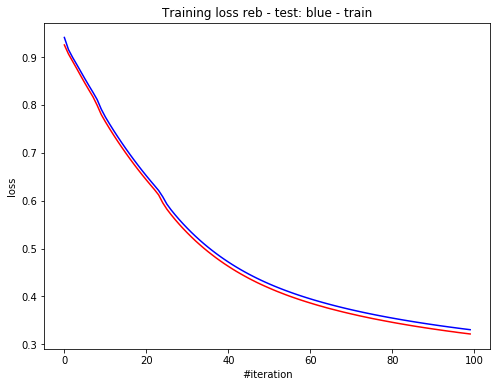

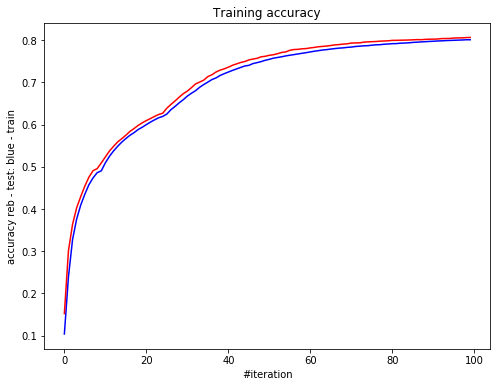

0.8062999999999999


In [10]:
print("Train ....")
ac1 = train(net, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)

# Вторая нейронка
Теперь в качестве критерия сходимости возьмем softmax кросэнторопию

In [ ]:

# (re-)load layers
%run homework_modules.ipynb


In [15]:

net2 = Sequential()
net2.add(Linear(28 * 28, 14 * 14))
net2.add(LeakyReLU())
net2.add(Linear(14 * 14, 7 * 7))
net2.add(LeakyReLU())
net2.add(Linear(7 * 7, 10))
net2.add(LeakyReLU())

criterion = CrossentropySoftMaxCriterion()



Train ....


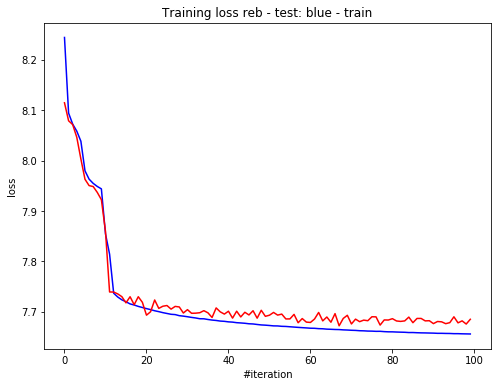

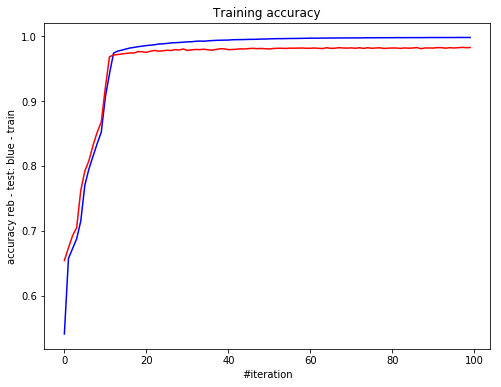

0.9823999999999999


In [16]:
print("Train ....")
ac1 = train(net2, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)


In [ ]:
# Третья нейронка
Добавим dropout слой для предотвращения переобучения


In [ ]:

# (re-)load layers
%run homework_modules.ipynb


In [24]:
net3 = Sequential()
net3.add(Linear(28 * 28, 14 * 14))
net3.add(LeakyReLU())
net3.add(Dropout())
net3.add(Linear(14 * 14, 7 * 7))
net3.add(LeakyReLU())
net3.add(Linear(7 * 7, 10))
net3.add(LeakyReLU())

criterion = CrossentropySoftMaxCriterion()


Train ....


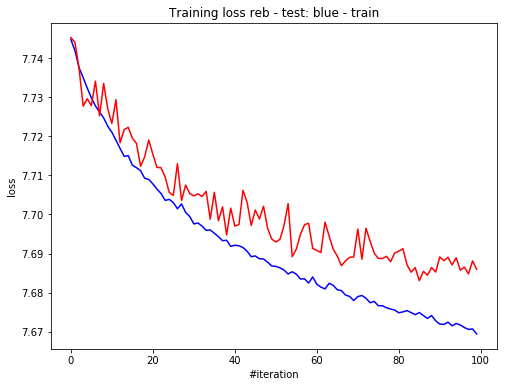

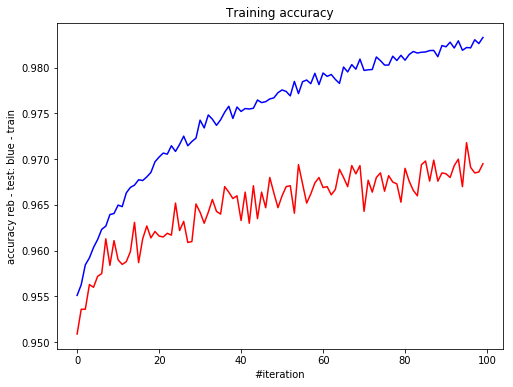

0.9695


In [26]:
print("Train ....")
ac1 = train(net3, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)


In [ ]:
# Четвертая нейронка
Добавим dropout слой на нижний слой нейронки и посмотрим что будет.


In [ ]:

# (re-)load layers
%run homework_modules.ipynb


Train ....


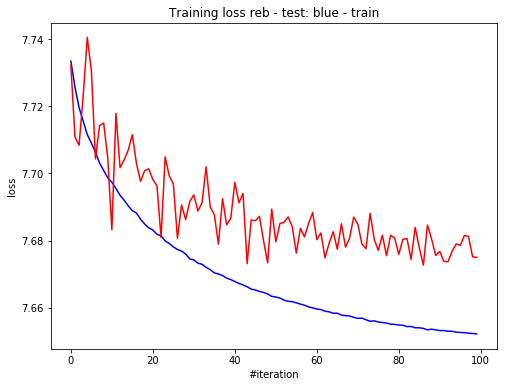

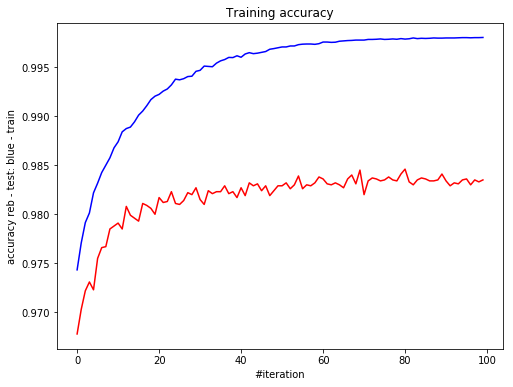

0.9835


In [30]:

net4 = Sequential()
net4.add(Linear(28 * 28, 14 * 14))
net4.add(LeakyReLU())
net4.add(Dropout())
net4.add(Linear(14 * 14, 7 * 7))
net4.add(LeakyReLU())
net4.add(Dropout())
net4.add(Linear(7 * 7, 10))
net4.add(LeakyReLU())

criterion = CrossentropySoftMaxCriterion()
print("Train ....")
ac1 = train(net, X_train, y_train, X_test, y_test, 100)
print(ac1)
test_acs.append(ac1)


In [33]:

from tabulate import tabulate

print(tabulate([['Net1', test_acs[0]], ['Net2', test_acs[1]], ['Net3', test_acs[2]], ['Net4', test_acs[3]]], headers=['Net', 'Accuracy']))




Net      Accuracy
-----  ----------
Net1       0.8063
Net2       0.9824
Net3       0.9695
Net4       0.9835
